# Import Package

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
# Regular expressions
import re

# LightGBM
import lightgbm as lgb

# sklearn tools for model training and assesment
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, auc, accuracy_score)
from sklearn.model_selection import GridSearchCV


# Import Data

In [44]:
#%% Import data
# Import both data sets
# trainRaw = pd.read_csv('input/train.csv')
# testRaw = pd.read_csv('input/test.csv')
trainRaw = pd.read_csv('train.csv')
testRaw = pd.read_csv('test.csv')

# And concatonate together
nTrain = trainRaw.shape[0]
full = pd.concat([trainRaw, testRaw],
                 axis=0)


## Tuple ADD

In [45]:
vec_add = lambda a,b : tuple([x+y for x,y in zip(a,b)])
vec_add(testRaw.shape,trainRaw.shape)
testRaw.shape + trainRaw.shape

(418, 11, 891, 12)

# Feature Engineering

In [46]:

# %% Cabins

def ADSplit(s):
    """
    Function to try and extract cabin letter and number from the cabin column.
    Runs a regular expression that finds letters and numbers in the
    string. These are held in match.group, if they exist.
    """

    match = re.match(r"([a-z]+)([0-9]+)", s, re.I)

    try:
        letter = match.group(1)
    except:
        letter = ''

    try:
        number = match.group(2)
    except:
        number = 9999

    return letter, number


def DR(s):
    """
    From the cabin string, try and extract letter, number, and number of cabins
    """
    # Check contents
    if isinstance(s, (int, float)):
        # If field is empty, return nothing
        letter = ''
        number = ''
        nRooms = 9999
    else:
        # If field isn't empty, split sting on space. Some strings contain
        # multiple cabins.
        s = s.split(' ')
        # Count the cabins based on number of splits
        nRooms = len(s)
        # Just take first cabin for letter/number extraction
        s = s[0]

        letter, number = ADSplit(s)

    return [letter, number, nRooms]

# Apply DR function to each cell in Cabin column using pandas apply method.
out = full['Cabin'].apply(DR)
# Outout tuple with 3 values for each row, convert this to pandas df
out = out.apply(pd.Series)
# And name the columns
out.columns = ['CL', 'CN', 'nC']

# Then concatenate these columns to the dataset
full = pd.concat([full, out],
                 axis=1)


# %% Family
# Add some family features directly to new columns in the dataset

# Size
full['fSize'] = full['SibSp'] + full['Parch'] + 1
# Ratio
full['fRatio'] = (full['Parch'] + 1) / (full['SibSp'] + 1)
# Adult?
full['Adult'] = full['Age'] > 18


# %% Names

# Extract titles from Name column, standardise
titleDict = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Sir",
    "Don": "Sir",
    "Sir": "Sir",
    "Dr": "Dr",
    "Rev": "Rev",
    "theCountess": "Lady",
    "Dona": "Lady",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr": "Mr",
    "Mrs": "Mrs",
    "Miss": "Miss",
    "Master": "Master",
    "Lady": "Lady"
}


def splitName(s, titleDict):
    """
    Extract title from name, replace with value in title dictionary. Also
    return surname.
    """

    # Remove '.' from name string
    s = s.replace('.', '')
    # Split on spaces
    s = s.split(' ')
    # get surname
    surname = s[0]

    # Get title - loop over titleDict, if s matches a key, take the
    # corresponding value as the title
    title = [t for k, t in titleDict.items() if str(k) in s]

    # If no matching keys in title dict, use 'Other'.
    if title == []:
        title = 'Other'
    else:
        # Title is a list, so extract contents
        title = title[0]

    # Return surname (stripping remaining ',') and title as string
    return surname.strip(','), title


# Apply functions to df and concatenate new columns as before
out = full['Name'].apply(splitName,
                         args=[titleDict])
out = out.apply(pd.Series)
out.columns = ['Surname', 'Title']

full = pd.concat([full, out],
                 axis=1)


# %% Categorical columns
# List of categorical columns to recode
catCols = ['Sex', 'Embarked', 'CL', 'CN', 'Surname', 'Title']

# Recode
for c in catCols:
    # Convert column to pd.Categotical
    full[c] = pd.Categorical(full[c])
    # Extract the cat.codes and replace the column with these
    full[c] = full[c].cat.codes
    # Convert the cat codes to categotical...
    full[c] = pd.Categorical(full[c])


# Generate a logical index of categorical columns to maybe use with LightGBM later
catCols = [i for i,v in enumerate(full.dtypes) if str(v)=='category']


#%% Age
# Replace missing age values with median.
# See ither kernels for more sophisticated ways of doing this!
full.loc[full.Age.isnull(), 'Age'] = np.median(full['Age'].loc[full.Age.notnull()])


#%% Split datasets
train = full.iloc[0:nTrain,:]
test = full.iloc[nTrain::,:]


#%% Prepare data
def prepLGB(data,
            classCol='',
            IDCol='',
            fDrop=[]):

        # Drop class column
        if classCol != '':
            labels = data[classCol]
            fDrop = fDrop + [classCol]
        else:
            labels = []

        if IDCol != '':
            IDs = data[IDCol]
        else:
            IDs = []

        if fDrop != []:
           data = data.drop(fDrop,
                            axis=1)

        # Create LGB mats
        lData = lgb.Dataset(data, label=labels,
                            free_raw_data=False,
                            feature_name=list(data.columns),
                            categorical_feature='auto')

        return lData, labels, IDs, data



# Data Partitions

In [47]:

# Specify columns to drop
fDrop = ['Ticket', 'Cabin', 'Name']

# Split training data in to training and validation sets.
# Validation set is used for early stopping.
trainData, validData = train_test_split(train,
                                        test_size=0.3,
                                        stratify=train.Survived)

# Prepare the data sets
trainDataL, trainLabels, trainIDs, trainData = prepLGB(trainData,
                                                 classCol='Survived',
                                                 IDCol='PassengerId',
                                                 fDrop=fDrop)

validDataL, validLabels, validIDs, validData = prepLGB(validData,
                                                 classCol='Survived',
                                                 IDCol='PassengerId',
                                                 fDrop=fDrop)

testDataL, _, _ , testData = prepLGB(test,
                                 classCol='Survived',
                                 IDCol='PassengerId',
                                 fDrop=fDrop)

# Prepare data set using all the training data
allTrainDataL, allTrainLabels, _ , allTrainData = prepLGB(train,
                                                 classCol='Survived',
                                                 IDCol='PassengerId',
                                                 fDrop=fDrop)


# Parameter Setting

## Fixed Parameter

In [56]:
# Set params
# Scores ~0.784 (without tuning and early stopping)
params = {'boosting_type': 'gbdt',
          'max_depth' : 5000,
          'objective': 'binary',
          'nthread': 6, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error',
          'n_estimators' : 1000}


## Grid Parameter

In [49]:
# Create parameters to search
gridParams = {
    'learning_rate': [0.005],
    'n_estimators': [1000],
    'num_leaves': [6,8,12,16],
    'boosting_type' : ['gbdt'],
    'objective' `b: ['binary'],
    'random_state' : [501], # Updated from 'seed'
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }


## Model Setting


In [57]:
# Create classifier to use. Note that parameters have to be input manually
# not as a dict!
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 5, # Updated from 'nthread'
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])


In [58]:
# To view the default model params:
mdl.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq', 'max_bin', 'scale_pos_weight'])

## Grid Search

In [61]:
# Create the grid
grid= GridSearchCV(mdl, gridParams,
                    verbose=0,
                    cv=4,
                    n_jobs=2)
# Run the grid
grid.fit(allTrainData, allTrainLabels)
# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

GridSearchCV(cv=4,
             estimator=LGBMClassifier(max_bin=512, max_depth=5000,
                                      min_child_samples=5, min_child_weight=1,
                                      min_split_gain=0.5, n_jobs=5,
                                      objective='binary', scale_pos_weight=1,
                                      subsample=1, subsample_for_bin=200,
                                      subsample_freq=1),
             n_jobs=2,
             param_grid={'boosting_type': ['gbdt'],
                         'colsample_bytree': [0.65, 0.66],
                         'learning_rate': [0.005], 'n_estimators': [1000],
                         'num_leaves': [6, 8, 12, 16], 'objective': ['binary'],
                         'random_state': [501], 'reg_alpha': [1, 1.2],
                         'reg_lambda': [1, 1.2, 1.4],
                         'subsample': [0.7, 0.75]})

In [64]:
# Using parameters already set above, replace in the best from the grid search
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate']
# params['max_bin'] = grid.best_params_['max_bin']
params['num_leaves'] = grid.best_params_['num_leaves']
params['reg_alpha'] = grid.best_params_['reg_alpha']
params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']
# params['subsample_for_bin'] = grid.best_params_['subsample_for_bin']

print('Fitting with params: ')
print(params)

Fitting with params: 
{'boosting_type': 'gbdt', 'max_depth': 5000, 'objective': 'binary', 'nthread': 6, 'num_leaves': 12, 'learning_rate': 0.005, 'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 0.7, 'subsample_freq': 1, 'colsample_bytree': 0.65, 'reg_alpha': 1, 'reg_lambda': 1, 'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 'metric': 'binary_error', 'n_estimators': 1000}


# Model Training

{'boosting_type': 'gbdt', 'colsample_bytree': 0.65, 'learning_rate': 0.005, 'n_estimators': 1000, 'num_leaves': 12, 'objective': 'binary', 'random_state': 501, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7}
0.8092402941057649
Fitting with params: 
{'boosting_type': 'gbdt', 'max_depth': 5000, 'objective': 'binary', 'nthread': 6, 'num_leaves': 12, 'learning_rate': 0.005, 'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 0.7, 'subsample_freq': 1, 'colsample_bytree': 0.65, 'reg_alpha': 1, 'reg_lambda': 1, 'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 'metric': 'binary_error'}
Fitting model 4
Training until validation scores don't improve for 1000 rounds
[4]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[8]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[12]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[16]	training's binary_error: 0.383895	valid_1's binary_

[556]	training's binary_error: 0.117978	valid_1's binary_error: 0.204482
[560]	training's binary_error: 0.117978	valid_1's binary_error: 0.207283
[564]	training's binary_error: 0.117978	valid_1's binary_error: 0.207283
[568]	training's binary_error: 0.117978	valid_1's binary_error: 0.210084
[572]	training's binary_error: 0.117978	valid_1's binary_error: 0.210084
[576]	training's binary_error: 0.116105	valid_1's binary_error: 0.210084
[580]	training's binary_error: 0.116105	valid_1's binary_error: 0.210084
[584]	training's binary_error: 0.116105	valid_1's binary_error: 0.207283
[588]	training's binary_error: 0.116105	valid_1's binary_error: 0.204482
[592]	training's binary_error: 0.116105	valid_1's binary_error: 0.201681
[596]	training's binary_error: 0.116105	valid_1's binary_error: 0.201681
[600]	training's binary_error: 0.116105	valid_1's binary_error: 0.204482
[604]	training's binary_error: 0.114232	valid_1's binary_error: 0.210084
[608]	training's binary_error: 0.114232	valid_1's b

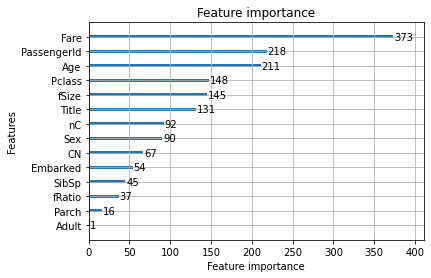

Fitting model 4
Training until validation scores don't improve for 1000 rounds
[4]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[8]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[12]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[16]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[20]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[24]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[28]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[32]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[36]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[40]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[44]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[48]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[52]	training's binary_error: 0.383895	valid_1's binary_err

[540]	training's binary_error: 0.125468	valid_1's binary_error: 0.193277
[544]	training's binary_error: 0.125468	valid_1's binary_error: 0.190476
[548]	training's binary_error: 0.125468	valid_1's binary_error: 0.190476
[552]	training's binary_error: 0.125468	valid_1's binary_error: 0.190476
[556]	training's binary_error: 0.125468	valid_1's binary_error: 0.193277
[560]	training's binary_error: 0.125468	valid_1's binary_error: 0.193277
[564]	training's binary_error: 0.125468	valid_1's binary_error: 0.190476
[568]	training's binary_error: 0.125468	valid_1's binary_error: 0.193277
[572]	training's binary_error: 0.125468	valid_1's binary_error: 0.193277
[576]	training's binary_error: 0.125468	valid_1's binary_error: 0.193277
[580]	training's binary_error: 0.125468	valid_1's binary_error: 0.190476
[584]	training's binary_error: 0.125468	valid_1's binary_error: 0.190476
[588]	training's binary_error: 0.125468	valid_1's binary_error: 0.190476
[592]	training's binary_error: 0.125468	valid_1's b

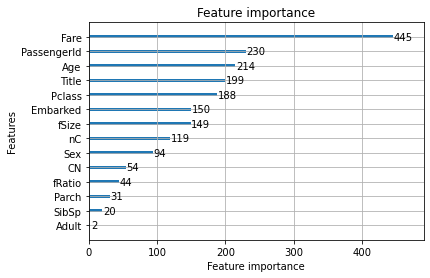

Fitting model 4
Training until validation scores don't improve for 1000 rounds
[4]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[8]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[12]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[16]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[20]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[24]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[28]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[32]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[36]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[40]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[44]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[48]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[52]	training's binary_error: 0.383895	valid_1's binary_err

[612]	training's binary_error: 0.142322	valid_1's binary_error: 0.182073
[616]	training's binary_error: 0.142322	valid_1's binary_error: 0.182073
[620]	training's binary_error: 0.142322	valid_1's binary_error: 0.182073
[624]	training's binary_error: 0.142322	valid_1's binary_error: 0.184874
[628]	training's binary_error: 0.142322	valid_1's binary_error: 0.187675
[632]	training's binary_error: 0.142322	valid_1's binary_error: 0.187675
[636]	training's binary_error: 0.142322	valid_1's binary_error: 0.187675
[640]	training's binary_error: 0.142322	valid_1's binary_error: 0.187675
[644]	training's binary_error: 0.144195	valid_1's binary_error: 0.187675
[648]	training's binary_error: 0.144195	valid_1's binary_error: 0.184874
[652]	training's binary_error: 0.142322	valid_1's binary_error: 0.187675
[656]	training's binary_error: 0.142322	valid_1's binary_error: 0.184874
[660]	training's binary_error: 0.142322	valid_1's binary_error: 0.187675
[664]	training's binary_error: 0.142322	valid_1's b

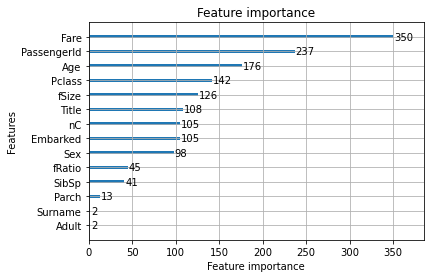

Fitting model 4
Training until validation scores don't improve for 1000 rounds
[4]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[8]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[12]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[16]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[20]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[24]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[28]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[32]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[36]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[40]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[44]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[48]	training's binary_error: 0.383895	valid_1's binary_error: 0.383754
[52]	training's binary_error: 0.383895	valid_1's binary_err

[564]	training's binary_error: 0.146067	valid_1's binary_error: 0.170868
[568]	training's binary_error: 0.146067	valid_1's binary_error: 0.173669
[572]	training's binary_error: 0.146067	valid_1's binary_error: 0.173669
[576]	training's binary_error: 0.146067	valid_1's binary_error: 0.170868
[580]	training's binary_error: 0.146067	valid_1's binary_error: 0.170868
[584]	training's binary_error: 0.146067	valid_1's binary_error: 0.168067
[588]	training's binary_error: 0.146067	valid_1's binary_error: 0.168067
[592]	training's binary_error: 0.144195	valid_1's binary_error: 0.173669
[596]	training's binary_error: 0.144195	valid_1's binary_error: 0.170868
[600]	training's binary_error: 0.144195	valid_1's binary_error: 0.170868
[604]	training's binary_error: 0.144195	valid_1's binary_error: 0.170868
[608]	training's binary_error: 0.144195	valid_1's binary_error: 0.170868
[612]	training's binary_error: 0.144195	valid_1's binary_error: 0.173669
[616]	training's binary_error: 0.144195	valid_1's b

[1396]	training's binary_error: 0.144195	valid_1's binary_error: 0.168067
[1400]	training's binary_error: 0.144195	valid_1's binary_error: 0.168067
[1404]	training's binary_error: 0.144195	valid_1's binary_error: 0.168067
[1408]	training's binary_error: 0.144195	valid_1's binary_error: 0.168067
[1412]	training's binary_error: 0.144195	valid_1's binary_error: 0.168067
[1416]	training's binary_error: 0.144195	valid_1's binary_error: 0.168067
[1420]	training's binary_error: 0.144195	valid_1's binary_error: 0.168067
[1424]	training's binary_error: 0.144195	valid_1's binary_error: 0.168067
[1428]	training's binary_error: 0.144195	valid_1's binary_error: 0.168067
[1432]	training's binary_error: 0.144195	valid_1's binary_error: 0.168067
[1436]	training's binary_error: 0.144195	valid_1's binary_error: 0.168067
[1440]	training's binary_error: 0.144195	valid_1's binary_error: 0.168067
[1444]	training's binary_error: 0.144195	valid_1's binary_error: 0.168067
[1448]	training's binary_error: 0.1441

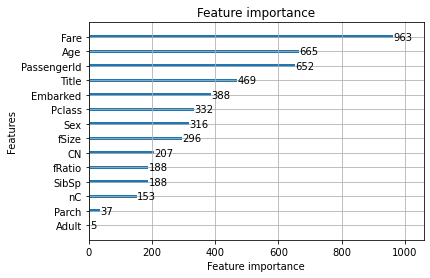

In [19]:
# Kit k models with early-stopping on different training/validation splits
k = 4
predsValid = 0
predsTrain = 0
predsTest = 0
for i in range(0, k):
    print('Fitting model', k)

    # Prepare the data set for fold
    trainData, validData = train_test_split(train,
                                            test_size=0.4,
                                            stratify=train.Survived)
    trainDataL, trainLabels, trainIDs, trainData = prepLGB(trainData,
                                                     classCol='Survived',
                                                     IDCol='PassengerId',
                                                     fDrop=fDrop)
    validDataL, validLabels, validIDs, validData = prepLGB(validData,
                                                     classCol='Survived',
                                                     IDCol='PassengerId',
                                                     fDrop=fDrop)
    # Train
    gbm = lgb.train(params,
                    trainDataL,
                    100000,
                    valid_sets=[trainDataL, validDataL],
                    early_stopping_rounds=1000,
                    verbose_eval=4)
    # Saving Model
    pickle.dump(gbm, open('LGBM'+str(i)+'.h5', "wb"))

    # Plot importance
    lgb.plot_importance(gbm)
    plt.show()

    # Predict
    predsValid += gbm.predict(validData,
                              num_iteration=gbm.best_iteration)/k
    predsTrain += gbm.predict(trainData,
                              num_iteration=gbm.best_iteration)/k
    predsTest += gbm.predict(testData,
                             num_iteration=gbm.best_iteration)/k


In [ ]:

# Print assessment
# assessMod(predsTrain, trainLabels, predsValid=predsValid, yValid= validLabels,
#           report=True, plot=True)

# Save submission
sub = pd.DataFrame()
sub['PassengerId'] = test['PassengerId']
sub['Survived'] = np.int32(predsTest > 0.5)
sub.to_csv('sub2.csv',
           index=False)